# SIHR Model - DFO Project
Supervised by: Prof. Laurent Dumas

Done by:- 
1. Mohammed Abdallah
2. Iyad Walwil 

### The Problem to Solve

We modeled the ***COVID epidemy*** with a ***SIHR*** model fitted with the real data during March and June 2020

(Precisely, March 18, 2020, until June 15, 2020)

#### The Real Data We Used

You can find and download the data we used on the website "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/#resource-d04f08bb-c79d-4801-bc11-d3565c1886a8-header" with the title "donnees-hospitalieres-groupees-covid19-2020-10-19-19h00"

### Problem Modeling

* $S(t)$: Fraction number of susceptible individuals 
* $I(t)$: Fraction number of ill-people
* $H(t)$: Fraction number of ill and hospitalized people (**real data**)
* $R(t)$: Fraction number of recovered people (or dead)

Such that:- 

$$S + I + H + R = 1$$

\begin{cases}
\frac{dS}{dt}(t) = - \beta(t) S(t) I(t) ~~~~~ \beta \geq 0 \\
\frac{dI}{dt}(t) =  \beta(t) S(t) I(t) - \alpha I(t) - \gamma_1 I(t) \\
\frac{dH}{dt}(t) =  \alpha I(t) - \gamma_2 H(t) \\
\frac{dR}{dt}(t) =  \gamma_1 I(t) + \gamma_2 H(t)
\end{cases}

Note that, Because of lockdown, we assume that $\beta$ has an exponentially decreasing shape:- 

$$\beta(t) = c\exp(- \lambda t)$$

### The Function to Minimize 

We aim to minimize the following function 
$$(c, \lambda, \alpha, \gamma_1, \gamma_2) \mapsto \sum_{\text{days}} (H_{model} - H_{data})^2$$

##### Importing the needed libraries 

In [ ]:
pip install pdfo         # Installing pdfo

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pdfo import pdfo

##### Reading the data

In [53]:
full_data = pd.read_csv('data/donnees-hospitalieres-groupees-covid19-2020-10-19-19h00.csv', sep=';') # March - October 2020
data = full_data[:90]         # Required data (March - June 2020)
data.head()

,jour,hosp,rea,rad,dc
0,18/03/2020,2972,771,816,218
1,19/03/2020,4073,1002,1180,327
2,20/03/2020,5226,1297,1587,450
3,21/03/2020,5900,1453,1811,525
4,22/03/2020,6954,1674,2117,632


###### Keeping the needed columns and getting rid of the others

We are just interested in the ***hosp*** column with the ***jour*** one 

In [54]:
data = data.drop(columns=['rea', 'rad', 'dc'])  # dropping the not required columns 

In [55]:
data

,jour,hosp
0,18/03/2020,2972
1,19/03/2020,4073
2,20/03/2020,5226
3,21/03/2020,5900
4,22/03/2020,6954
...,...,...
85,11/06/2020,11418
86,12/06/2020,11078
87,13/06/2020,10862
88,14/06/2020,10837


##### Data Normalization

In [56]:
Pop = 67.39e6         # French Population
data['hosp'] = data['hosp'].div(Pop)       # Normalization

In [57]:
data      # Data is ready right now!

,jour,hosp
0,18/03/2020,0.000044
1,19/03/2020,0.000060
2,20/03/2020,0.000078
3,21/03/2020,0.000088
4,22/03/2020,0.000103
...,...,...
85,11/06/2020,0.000169
86,12/06/2020,0.000164
87,13/06/2020,0.000161
88,14/06/2020,0.000161


##### Converting the "hospitalized" data to an $1\mathcal{D}$ array

In [58]:
H_data = data['hosp'].to_numpy()   # Array containing the Hospitalized data
n = len(H_data)
print(n)
# print(H_data)

90


#### Plotting the data

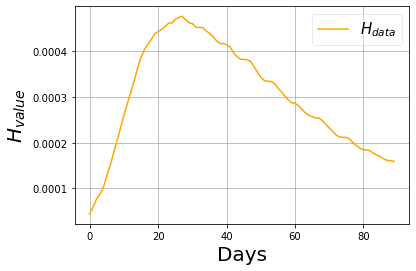

In [59]:
plt.close()
plt.plot(H_data, color = 'orange', label = '$H_{data}$')
plt.grid(which = 'both')
plt.ylabel("$H_{value}$", fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.legend(loc='upper right', fancybox=True, prop={'size':15}).get_frame().set_alpha(0.4)
plt.show()

### Solving the ,SIHR, ODE's System 
To solve the above system of ODE's, we used ***Euler's Method*** with:- 
1. **Initialization**
\begin{cases} S_0 = 1 - (I_0 + H_0 + R_0) \\ I_0 = 10 \times H_0 \\   H_0 = H_{data_0} \\ R_0 = 0 \end{cases}
2. **Step Size** $$h = 0.01$$

---------------------------------------

### Euler's Method 

Recall that for a given first order ODE, Euler's Method works as follows 
$$y_{n+1} = y_n + hf(t_n, y_n)$$

Projecting this formula in our framework, we can treat $y_{n+1}$ as a $4 \mathcal{D}$ vector where:- 
1. $y_{n} = \begin{bmatrix} S_n \\ I_n \\ H_n \\ R_n \end{bmatrix}$ $\hspace{7cm}$ 2. $f(t_n, y_n) = \begin{bmatrix} - \beta(t) S(t) I(t) \\  \beta(t) S(t) I(t) - \alpha I(t) - \gamma_1 I(t) \\ \alpha I(t) - \gamma_2 H(t)  \\ \gamma_1 I(t) + \gamma_2 H(t) \end{bmatrix}$



-------------------------

#####  Initialization

In [60]:
H_init = H_data[0]             
I_init = 10*H_init
R_init = 0
S_init = 1 - (H_init + I_init + R_init)

Y_init = np.array([S_init, I_init, H_init, R_init])
print(Y_init)

[9.99514884e-01 4.41014987e-04 4.41014987e-05 0.00000000e+00]


####  Euler's Method Algorithm

We have implemented in the next cell Euler's Method for some $t$

In [61]:
def euler_Method(t, y_prev, x0, h = 0.01):
    
    """  
    param t: time 
    param y_prev: represnts y_n in Euler's Method 
    param x0: the values of c, lambda, alpha, gamma1, and gamma2
    
    """
    Y = np.zeros(4)    # Y(t) = [S(t), I(t), H(t), R(t)]
    
    c, Lambda, alpha, gamma1, gamma2 = x0[0], x0[1], x0[2], x0[3], x0[4]
    
    # Finding Y_t+1 by using Euler's Method 
    beta = c*np.exp(-Lambda*t)
    Y[0] = y_prev[0] + h*(-beta*y_prev[0]*y_prev[1])
    Y[1] = y_prev[1] + h*(beta*y_prev[0]*y_prev[1] - alpha*y_prev[1] - gamma1*y_prev[1])
    Y[2] = y_prev[2] + h*(alpha*y_prev[1] - gamma2*y_prev[2])
    Y[3] = y_prev[3] + h*(gamma1*y_prev[1] + gamma2*y_prev[2])
    
    return Y

#### Computing of the Function to be Minimized

Computing the function $$(c, \lambda, \alpha, \gamma_1, \gamma_2) \mapsto \sum_{\text{days}} (H_{model} - H_{data})^2$$ to be minimzed afterwards by using several deterministic DFO algorithms 

In [62]:
def objective_function(x0, h = 0.01, y_init = Y_init):
    
    """  
    param x0: the values of c, lambda, alpha, gamma1, and gamma2 
    param h: is the step size, 0.01 as default value 
    param y_init: the initialization of Euler's Method
    
    """
    S = 0           # Initial value of our objective function 
    L = []          # List contining H_model (Y[2]) since Y = [S, I, H, R]
    Y = y_init
    L.append(Y[2])
    
    for t in range(n):
        TS = np.arange(t, t+1, h)         # Step size = 0.01 between any two days, so 100 evaluations 
        for tt in TS:
            Y = euler_Method(tt, Y, x0)
        L.append(Y[2])
        S += (Y[2] - H_data[t])**2          # Constructing the Objective Function to minimize 

        
    return (S,L)

************

## Direct Problem

We are going to run our objective function with some arbitrary values of the parameters $(c, \lambda, \alpha, \gamma_1, \gamma_2)$ to find the $H_{model}$ values and observe how much it's close to $H_{data}$

We will take the arbitrary values:- 
\begin{cases}  c = 0.5 \\ \lambda = 0.8 \\ \alpha = 0.1 \\ \gamma_1 = 0.1 \\ \gamma_2 = 0.1 \end{cases}

In [101]:
## Parameters
c = 0.5
Lambda = 0.8
alpha = 0.1
gamma1 = 0.1
gamma2 = 0.1

In [102]:
x0 = np.array([c, Lambda, alpha, gamma1, gamma2])
print('x0 = ',x0)
V = objective_function(x0)              # Objective Function value for the above parameters 
print('Objective Function = ', V[0])

x0 =  [0.5 0.8 0.1 0.1 0.1]
Objective Function =  7.808138671302364e-06


#### $H_{model}$ with arbitrary values of the parameters Vs. $H_{data}$

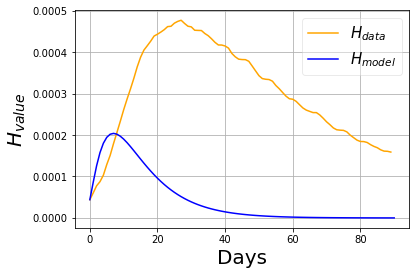

In [103]:
plt.close()
plt.plot(H_data, color = 'orange', label = '$H_{data}$')
plt.plot(V[1], color = 'blue', label = '$H_{model}$')
plt.grid(which = 'both')
plt.ylabel("$H_{value}$", fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.legend(loc='upper right', fancybox=True, prop={'size':15}).get_frame().set_alpha(0.4)
plt.show()

### Conclusion 
Obviously, with the chosen parameters we didn't have good values for $H_{model}$ which is logical since we chose them arbitrary

However, we can improve the above results a lot by choosing better values of the parameters, this can be done by implementing the ***Inverse Problem***

************

## Inverse Problem 

We applied 2 algorithms on our objective function in order to find out the optimal parameters and made some figures illustrate the performance of each of them. 

The applied algorithms:- 
1. Nelder Mead 
2. NEWUOA

##### Entering the "Dimension" & the # of "Iterations"

In [124]:
d = int(input("Enter the dimension of your problem: "))
ite = int(input("Enter the iterations number: "))

Enter the dimension of your problem: 5
Enter the iterations number: 300


******************

### Nelder - Mead

#### Defining the Simplex

In [73]:
S = np.ndarray(shape=(d+1,d), dtype = float)
S = ([[0.8,0.5,0.1,0.1,0.1], [1,0,0.5,0.7,0.005], [0.01,0.5,0.9,0.7,0.6],
              [0.8,0.75,0.45,0.9,0.1], [0,1,0.2,0.95,0.4], [0.15,0.33,0.5,0.7,0.1]])
# print(S)

#### Defining a specific function for "Ranking" the simplex

In [74]:
def ranking(S, fun = objective_function):
    
    """
    param S: Simplex
    param fun: the function we want to rank our simplex according to it
    """
    L = []                 # Defining this list L in order to compare the elements inside it afterwards 
    SS = np.zeros((d+1,d))
    for s in S:       
        L.append(fun(s)[0])
    K = max(L)               # Finding the max of L as our criterion to rank S, we will replace the min of S 
                                                                #  by (max + 1) 
    for i in range(len(L)):
        m = min(L)
        j = L.index(m)
        SS[i] = S[j]      # Inserting the element of S in SS with the index of the smallest element in L
        L[j] = K+1        # Replacing the min by (max + 1) in L, so it's not the min anymore 
        
    return SS

#### Defining Nelder-Mead for one step

In [78]:
def nelder_Mead_Step(S, fun = objective_function): 
    
    """
    param S: Simplex
    param fun: the function we want to rank our simplex according to it
    """
     
    O = 1/d
    R = S
    j = R[-1]         # the last element in R (the element with the greatest function value)
    xc = 0            
    for b in range(len(R) - 1):
        xc += O*R[b]              # Finding the barecenter 
        
    xr = j + 2*(xc - j)        # Calculating xr
    
    # Function value of some important points 
    fr = fun(xr)    
    f0 = fun(R[0])       # Function value of the first element in the simplex (the argmin of f)
    fn_1 = fun(R[-2])    # Function value of the penultimate element
    fj = fun(j)          # Function value of the last element (the argmax) (the one to replace)
    
    
    # 1st Case 
    if (fr < f0):
        xe = j + 3*(xc - j)    #Expansion 
        fe = fun(xe)
        if (fe < fr):
            R[-1] = xe
        else:
            R[-1] = xr
    # 2nd Case
    elif ((f0 <= fr) and (fr <= fn_1)):
          R[-1] = xr
    # 3rd Case
    elif ((fn_1 < fr) and (fr <= fj)):
        x_tilde = j + 1.5*(xc - j)      #Trying to find some thing better
        f_tilde = fun(x_tilde)
        if (f_tilde < fr):
            R[-1] = x_tilde
        else: 
            R[-1] = xr
    # 4th Case
    else:
        x_hat = j + 0.5*(xc - j)       # The Last attempt to avoid failure step 
        f_hat = fun(x_hat)
        if (f_hat < fj):
            R[-1] = x_hat
        else:                          # Failure Step :(
            for i in range(1,len(R)):
                R[i] = (R[i] + R[0])/2     #reconstructing the simplex
    R = ranking(R)
                
    return R

#### Defining the Nelder-Mead for a given function 

In [125]:
def nelder_Mead(S, K = ite, fun = objective_function, algorithm = nelder_Mead_Step):
    
    """
    param S: Simplex
    param K: Number of iterations
    param fun: the function we want to rank our simplex according to it
    """
    R = ranking(S)             # Ranking the initial simplex
    R = nelder_Mead_Step(R)    # Improving our simplex by using nelder-mead step 
    L = []
    L.append(objective_function(R[0]))
    for k in range(K):
        R = nelder_Mead_Step(R)         # Ranking our new simplex again and again at each iteration 
        L.append(objective_function(R[0]))   # Trying to imporove our simplex more and more 
#     print("R = ",R)
#     print("L = ", L)
    return (R, L)

#### Finding the Optimal Values of the Parameters 

In [130]:
res_1 = nelder_Mead(S)

In [131]:
print("S = ", res_1[0])
# print("L = ", res_2[1])

S =  [[1.61811263 0.37431338 0.00228969 0.01854106 0.09137186]
 [1.60147969 0.38396828 0.00256676 0.01848406 0.08764182]
 [1.59886857 0.38547767 0.00260864 0.01849719 0.08705952]
 [1.60137844 0.38396725 0.0025747  0.01865416 0.08764223]
 [1.60880905 0.37978147 0.00242264 0.01836075 0.08926241]
 [1.6058659  0.38152588 0.00246786 0.01825156 0.08858804]]


In [132]:
xm = res_1[0][0]
Vm = objective_function(xm)

#### $H_{model}$ with Optimal Parameters Vs. $H_{data}$

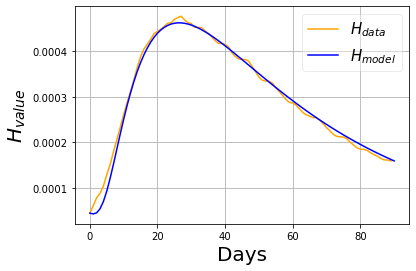

In [133]:
plt.close()
plt.plot(H_data, color = 'orange', label = '$H_{data}$')
plt.plot(Vm[1], color = 'blue', label = '$H_{model}$')
plt.grid(which = 'both')
plt.ylabel("$H_{value}$", fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.legend(loc='upper right', fancybox=True, prop={'size':15}).get_frame().set_alpha(0.4)
plt.show()

### Conclusion 

We observe a very good performance of the ***Nelder-Mead*** algorithm applied to our objective function 

**300 iterations** were enough to have a very good solution $$x^* = \begin{bmatrix} c \\ \lambda \\ \alpha \\ \gamma_1 \\ \gamma_2 \end{bmatrix} = \begin{bmatrix} 1.61811263 \\ 0.37431338 \\ 0.00228969 \\ 0.01854106 \\ 0.09137186 \end{bmatrix}$$

We can imagine that with some more iterations we can reach a perfectly optimal solution with a curve almost the same as the one for the data.

****************

## NEWUOA 

We are going to use NEWUOA algorithm implemented in the ***PDFO*** library 

In [90]:
def objective_Function(x0, h = 0.01, y_init = Y_init):
    
    """  
    param x0: the values of c, lambda, alpha, gamma1, and gamma2 
    param h: is the step size, 0.01 as default value 
    param y_init: the initialization of Euler's Method
    """
    
    S = 0
    L = []
    Y = y_init
    L.append(Y[2])
    
    for t in range(n):
        TS = np.arange(t, t+1, h)
        for tt in TS:
            Y = euler_Method(tt, Y, x0)
        L.append(Y[2])
        S += (Y[2] - H_data[t])**2  

        
    return S

In [92]:
pdfo(objective_Function, x0, method='NEWUOA', options={'maxfev': 10000, 'ftarget': 1e-8})

D:\Anaconda\lib\site-packages\pdfo\_dependencies.py:3149: Warning: pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1.2676506002282294e+30 are replaced by hugefun.
  warnings.warn(warn_message, Warning)


OptimizeResult(fhist=array([7.80813867e-06, 6.98439912e-06, 8.12916294e-06, 8.57541466e-06,
       9.21362827e-06, 9.47035667e-06, 8.75580612e-06, 8.17522031e-01,
       1.26765060e+30, 1.26765060e+30, 1.26765060e+30, 9.57965555e-06,
       9.46142999e-06, 7.10165427e-06, 8.95309166e-06, 1.05776691e-05,
       2.66362091e-06, 6.20681942e-07, 8.95348151e-06, 1.97167227e-06,
       2.81342676e-05, 9.48600500e-04, 3.13678983e-04, 4.63567931e-06,
       6.86053193e-06, 4.28124089e-06, 2.91140841e-06, 2.52229752e-05,
       6.30824527e-08, 7.93487118e-07, 2.11235676e-07, 8.89184148e-07,
       1.00303043e-07, 4.76343476e-07, 1.50847034e-06, 3.73081622e-07,
       1.56556959e-06, 3.85524523e-07, 1.21782903e-07, 6.94319127e-08,
       1.09080481e-07, 6.33675052e-08, 6.84623174e-08, 9.32741687e-08,
       6.87359442e-08, 6.12809273e-08, 5.89561049e-08, 7.29121734e-08,
       5.75005073e-08, 6.04234657e-08, 5.53325614e-08, 5.47012936e-08,
       7.54956895e-08, 5.56197319e-08, 5.48683845e-08, 5

In [93]:
xn = np.array([1.50573959, 0.44266261, 0.00432188, 0.02448721, 0.0541281])
Vn = objective_function(xn)

#### $H_{model}$ with Optimal Parameters Vs. $H_{data}$

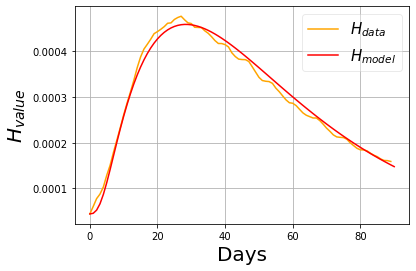

In [112]:
plt.close()
plt.plot(H_data, color = 'orange', label = '$H_{data}$')
plt.plot(Vn[1], color = 'red', label = '$H_{model}$')
plt.grid(which = 'both')
plt.ylabel("$H_{value}$", fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.legend(loc='upper right', fancybox=True, prop={'size':15}).get_frame().set_alpha(0.4)
plt.show()

### Conclusion 

As what we observed in the ***Nelder-Mead*** algorithm, ***NEWUOA*** came to emphasize the results with a very close solution to the one by Nelder-Mead.

Again, with $f_{target} = 10^{-8}$, which is not that small for our objective function, we got a very good solution  
$$x^* = \begin{bmatrix} c \\ \lambda \\ \alpha \\ \gamma_1 \\ \gamma_2 \end{bmatrix} = \begin{bmatrix} 1.50573959 \\ 0.44266261 \\ 0.00432188 \\ 0.02448721 \\ 0.0541281 \end{bmatrix}$$

What about smaller $f_{target}$? let's combine everything together and see!

****************

## All Together!

We are going to plot $H_{model}$ Vs. $H_{data}$ we obtained by the 2 algorithms applied above for more accurate solutions 

Basically:-
1. Nelder-Mead with $10^3$ iterations 
2. NEWUOA with $f_{target} = 10^{-12}$

##### Nelder_Mead with $10^3$ Iterations

In [134]:
res_2 = nelder_Mead(S, 1000)

In [141]:
xm_2 = res_1[0][0]
Vm_2 = objective_function(xm)

##### NEWUOA with $f_{target} = 10^{-12}$

In [153]:
pdfo(objective_Function, x0, method='NEWUOA', options={'maxfev': 1000000, 'ftarget': 1e-12})

OptimizeResult(fhist=array([7.80813867e-06, 6.98439912e-06, 8.12916294e-06, ...,
       3.29104374e-09, 3.29107117e-09, 3.29104436e-09]), fun=3.2910430736958852e-09, message='Return from newuoa because the lower bound for the trust region radius is reached.', method='newuoa', nfev=2444, status=0, success=True, warnings=['pdfo: extreme barrier is invoked; function values that are NaN or larger than hugefun=1.2676506002282294e+30 are replaced by hugefun.'], x=array([1.51479209, 0.36209286, 0.00248023, 0.02066094, 0.07937818]))

In [154]:
xn_2 = np.array([1.51479209, 0.36209286, 0.00248023, 0.02066094, 0.07937818])
Vn_2 = objective_function(xn)

### The Power of the Inverse Type Problem in a Graph! 

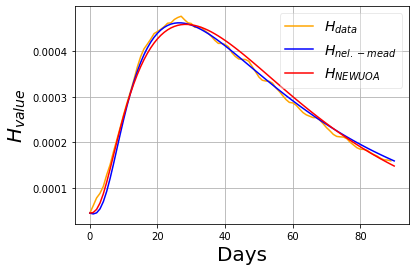

In [155]:
plt.close()
plt.plot(H_data, color = 'orange', label = '$H_{data}$')
plt.plot(Vm_2[1], color = 'blue', label = '$H_{nel.-mead}$')
plt.plot(Vn_2[1], color = 'red', label = '$H_{NEWUOA}$')
plt.grid(which = 'both')
plt.ylabel("$H_{value}$", fontsize=20)
plt.xlabel("Days", fontsize=20)
plt.legend(loc='upper right', fancybox=True, prop={'size':14}).get_frame().set_alpha(0.4)
plt.show()

## Conclusion 

1. The curves show how much these 2 algorithms are powerful. They have a very good, and pretty fast convergence, which coincide with what we have seen during the course.
2. It's hard to say that one of them is better than the other. However, we may observe that ***Nelder-Mead*** gave, somehow, a better curve than ***NEWUOA***.
3. It's obviously observed how much it differs between the direct and inverse problems, which reflects the power of the ***Inverse Type Problems Principle***.